In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
import math
sys.path.append('/home/eduardo/PycharmProjects/treemap-analysis/code')

import Parser
import SpatialMetrics

In [2]:
dataset_id = 'exo'

In [53]:
df = SpatialMetrics.aggregated_ar('git', dataset_id)
df = df.T

data = []
for r in df.as_matrix():
    data.append(r[~np.isnan(r)])


{'boxes': [<matplotlib.patches.PathPatch at 0x7f5ae6d26f98>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5ae6d96c88>,
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x7f5ae6d7d710>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5ae6d857f0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5ae6d215c0>,
  <matplotlib.lines.Line2D at 0x7f5ae611fc88>]}

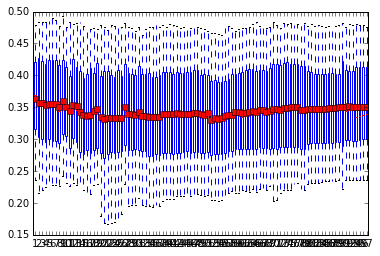

In [59]:
plt.figure()
plt.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True,
                             showmeans=True)